# One Class Support Vector Machines

## Importing Libraries

In [61]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

from scipy.stats import scoreatpercentile

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Data Management

In [44]:
# READ INFECTION TIME DATA
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# READ AND EXTRACT DATA FROM FOLDER CONTAINING EXCEL SHEETS
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"
files = glob.glob( folder + "Ex *.xlsx" ) 

In [45]:
# CREATE A LIST OF TEMPERATURES
temp = []

for file in files:
    df = pd.read_excel(file)
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        
        # Append the temperature and minutes to each lists
        temp.append(temperature)

## Creating Data Frames

In [46]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
infection_data = infection_data.T # transpose the data

infection_data.columns = infection_data.iloc[0] # Assign the values of the first row as the new column names

infection_data = infection_data[1:] # Remove the first row (previous column names)


##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T # transpose the data

df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0] # Rename columns keeping only the first word


## Scores

In [5]:
# IMPORTING THE SVM MODEL
# this model is from SckiKit Learn
model = svm.OneClassSVM()

# SIGMOID DEFINITION
# we will use the sigmoid function to make our scores be a numerical value that lies between 0 and 1

beta = (2/700) # 700 is the largest value
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

In [62]:
#fig,ax = plt.subplots(2,1,figsize=(15,10), sharex = False)
#fig.set_facecolor("white")
#classifier_tree = DecisionTreeClassifier()
train_end = 4320
shift = 2*360 # since the period is 6 hours (360) and we do this twice

# LISTS

# Create a dictionary to store results based on infection time
results_by_infection_time = {}

# First anomalies after infection

min_scores = []
first_anom_train = []
first_anom_inf = []
score_train = []
score_infec = []
recall_anom = []
precision_anom = []
f1_anom = []
tpr = []


for i in range(0, df_temp.shape[1]): #df_temp.shape[1]
    #ax[0].cla()  # clear axis 0-1
    #ax[1].cla()
    
    #mice_min = range(0, df_temp.shape[0]) # Get the specific minutes for the current temperature time series
    
    temp_value = df_temp.iloc[:, i] # extract the temperature values for the current column
    mice_temp = df_temp.iloc[:, i].to_frame() # converting temp list to data frame
    
    names = mice_temp.columns[0] # get the column name for the current file
    
    ##################################################################
    # Finding Infection Time
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
        ##################################################################
        # Filing in missing data
        temp_value_fw = temp_value.fillna(method='ffill') # foward fill
        temp_value_bw = temp_value_fw.fillna(method='bfill') # backward fill after forward fill

        # Time Delay Embedding
        temp_tde = tde.tde(temp_value_bw) # using the tde file
        temp_tde = temp_tde.T # transporting the data

        ##################################################################
        # Fit the Data on the first 3 days (3*24*60) 
        model.fit(temp_tde[:train_end+1,:])

        # Predict the Data
        predict_train_data = model.predict(temp_tde[:train_end+1,:]) # predict on training data
        predict_test_data = model.predict(temp_tde[train_end+1:,:]) # predicting on test data

        # Scores
        scores_train_data = model.score_samples(temp_tde[:train_end+1,:]) # scores on training data 
        scores_test_data = model.score_samples(temp_tde[train_end+1:,:]) # scores on test data

        threshold = model.offset_

        ##################################################################
        # Combine training and testing scores and predictions
        combined_scores= np.concatenate((scores_train_data, scores_test_data), axis=0)
        combined_predictions = np.concatenate((predict_train_data, predict_test_data), axis=0)

        time = np.arange(temp_tde.shape[0])+(shift) # 2 times the time delay shift

        # Minimum score
        min_score = scores_train_data.min()

        # Find the indices of the anomalies
        anomaly_indices = np.where(combined_scores <= min_score)[0] #finding the values where its -1 (anomaly)
        time_2 = anomaly_indices + (shift) # shifting the time for plotting
        
        ##################################################################
        # Find the index at which the first score is less than min_score
        boolean = combined_scores < min_score
        anom_train = np.argmax(boolean) # first anomaly after training period
        anom_infec = np.argmax(boolean[infection_time-shift:]) + infection_time # first anomaly after infection period

        
        # Set up for classification report
        dataset_len_train = len(combined_scores)+shift-train_end # finding the length of the testing dataset
        train_to_inf = combined_scores[train_end-shift : infection_time-shift]
        post_inf = combined_scores[infection_time-shift : ]
        true_neg = np.zeros(len(train_to_inf))
        true_pos = np.ones(len(post_inf))
        y_true = np.append(true_neg, true_pos, axis=0)  # Appends along row
        
        #y_true = np.ones(dataset_len_train) # creating an array of zeroes of that length
        ones_and_zeros_array = boolean.astype(int) # turning boolean outcomes into ones and zeros
        y_pred = ones_and_zeros_array[train_end-shift: ]
        target_names = ['Nonanomalies', 'Anomalies']
        #print(classification_report(y_true, y_pred, target_names=target_names, output_dict=True))
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1_score = precision_recall_fscore_support(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels = [0,1])
        #print(cm)
        
        
        # Get the corresponding value
        value = combined_scores[anom_train]
        value_1 = combined_scores[anom_infec-shift]

        # Calculating the time first anomaly was found after training and infection
        time_aft_train = (anom_train + shift) - train_end
        time_aft_infection = anom_infec - infection_time

        # Calculating the amount of false negatives (between end of train and infection time)
        #count_false_neg = np.count_nonzero(boolean[train_end:infection_time])
        count_false_neg = np.count_nonzero(ones_and_zeros_array[infection_time-shift : ] == 0)
        
        # Calculating the amount of true positives (infection time)
        #count_true_pos = np.count_nonzero(boolean[infection_time:]) 
        count_true_pos = np.count_nonzero(ones_and_zeros_array[infection_time-shift : ] == 1)
        
        # Calculating true positive rate
        # Check if the denominator is zero
        if (count_true_pos + count_false_neg) == 0:
            print("N/A")
            continue  # Skip this iteration and move to the next number
        
        TPR = count_true_pos / (count_true_pos + count_false_neg)
        
       
        
        ##################################################################
        '''
        # Plotting 2nd Graph
        ax[1].plot(time, combined_scores, '-', color='#6693F5', alpha=0.75)  # Plot the scores with blue color #[:100]
        ax[1].plot(time_2, combined_scores[anomaly_indices], '', color='purple') #coloring anomalies
        ax[1].grid()
        ax[1].set_ylabel("Score", fontsize=14)
        ax[1].set_xlabel("Minutes", fontsize=14)
        ax[1].set_title(f"Anomalies found using our threshold for '{names}'", fontsize=14)
        #ax[1].set_xlim(infection_time-5,infection_time+30)
        ax[1].set_xlim(-10,26000)
        ax[1].set_ylim(0,700)

        ##################################################################
        # Plotting Horizontal and Vertical Lines
        ax[1].axvline(x = anom_train+shift, color='blue', linestyle='--', label='First anomaly after training') # when the first value is less the minimum value
        ax[1].axvline(x = train_end, color='green', linestyle='-', label='End of training data')
        ax[1].axhline(y=min_score, color='red', linestyle='-', label='Threshold')
        ax[1].axvline(x = anom_infec, color='orange', linestyle ='-', label='First anomaly after infection')
        #ax[1].axhline(y=value, color='blue', linestyle='--', label='value')
        #ax[1].axhline(y=value_1, color='orange', linestyle='-', label='value_1')
        ax[1].legend()

        ##################################################################
        # Print Values
        print("Minimum Score: ", min_score)
        print("After Training Min: ", anom_train+shift)
        print("After Infection Min: ", anom_infec)
        print(f"First anomaly found after training: {time_aft_train} minutes with score {value}")
        print(f"First anomaly found after infection: {time_aft_infection} minutes with score {value_1}")
        print(f"True Positve Rate: {TPR*100}%")
        
        '''

        ##################################################################
        # Appending to Lists
        min_scores.append(min_score)
        first_anom_train.append(time_aft_train)
        first_anom_inf.append(time_aft_infection)
        score_train.append(value)
        score_infec.append(value_1)
        recall_anom.append(recall)
        precision_anom.append(precision)
        f1_anom.append(f1_score)
        tpr.append(TPR)
    
    else:
        print(f"No match found for mouse '{names}'")
    
    print("====================================")
    


    
    
   
    
    
    
    
    
    
'''

print("Average Minimum Scores by Infection Time:", average_min_scores_by_infection_time)
    
for infection_time, results in results_by_infection_time.items():
    print(f"Results for infection time {infection_time}:")
    print("Min Scores:", results['min_scores'])
    print("First Anomaly Train:", results['first_anom_train'])
    # ... print other results ...
    print("====================================")
    ##################################################################
    
 '''   

Found 'CC006-315' and its infection value is '10300'
Found 'CC006-316' and its infection value is '10300'
Found 'CC006-317' and its infection value is '10300'
Found 'CC019-1392' and its infection value is '10300'
No match found for mouse 'CC019-1393'
Found 'CC043-455' and its infection value is '10300'


/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 'CC043-456' and its infection value is '10300'
Found 'CC043-457' and its infection value is '10300'


/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 'CC051-489' and its infection value is '10300'
Found 'CC051-490' and its infection value is '10300'
Found 'CC057-610' and its infection value is '10300'
Found 'CC002-607' and its infection value is '11250'
Found 'CC002-609' and its infection value is '11250'
Found 'CC002-610' and its infection value is '11250'
Found 'CC003-178' and its infection value is '11250'
Found 'CC003-179' and its infection value is '11250'
Found 'CC003-180' and its infection value is '11250'
Found 'CC005-433' and its infection value is '11250'
Found 'CC005-434' and its infection value is '11250'
Found 'CC005-435' and its infection value is '11250'
No match found for mouse 'CC011-564'
No match found for mouse 'CC011-565'
No match found for mouse 'CC011-566'
Found 'CC013-642' and its infection value is '11250'
Found 'CC013-643' and its infection value is '11250'
Found 'CC013-644' and its infection value is '11250'
No match found for mouse 'B6-103'
Found 'CC001-364' and its infection value is '10250'
Found '

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 'CC036-299' and its infection value is '10250'
No match found for mouse 'B6-100'
No match found for mouse 'B6-101'
Found 'CC002-557' and its infection value is '14200'
Found 'CC002-558' and its infection value is '14200'
Found 'CC002-559' and its infection value is '14200'
Found 'CC015-390' and its infection value is '14200'
Found 'CC015-391' and its infection value is '14200'
Found 'CC015-392' and its infection value is '14200'
Found 'CC038-582' and its infection value is '14200'
Found 'CC038-583' and its infection value is '14200'
Found 'CC051-495' and its infection value is '14200'
Found 'CC051-496' and its infection value is '14200'
Found 'CC006-507' and its infection value is '10500'
Found 'CC006-508' and its infection value is '10500'
Found 'CC017-413' and its infection value is '10500'
Found 'CC036-276' and its infection value is '10500'
Found 'CC036-279' and its infection value is '10500'
No match found for mouse 'CC036-280'
Found 'CC036-281' and its infection value is '1

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 'CC005-410' and its infection value is '14300'
Found 'CC005-411' and its infection value is '14300'
Found 'CC019-1445' and its infection value is '14300'
Found 'CC019-1451' and its infection value is '14300'
Found 'CC019-1452' and its infection value is '14300'
Found 'CC023-567' and its infection value is '14300'
Found 'CC023-568' and its infection value is '14300'
Found 'CC023-569' and its infection value is '14300'
Found 'CC023-571' and its infection value is '14300'
Found 'CC023-572' and its infection value is '14300'
Found 'CC023-577' and its infection value is '14300'
No match found for mouse 'CC023-578'
No match found for mouse 'B6-102'
No match found for mouse 'CC003-184'
Found 'CC003-187' and its infection value is '10250'
Found 'CC003-190' and its infection value is '10250'
Found 'CC012-1348' and its infection value is '10250'
Found 'CC012-1349' and its infection value is '10250'
Found 'CC012-1350' and its infection value is '10250'
Found 'CC012-1354' and its infection v

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 'CC036-290' and its infection value is '10500'
Found 'CC043-607' and its infection value is '10500'
Found 'CC058-317' and its infection value is '10500'
Found 'CC058-318' and its infection value is '10500'
Found 'CC058-319' and its infection value is '10500'
Found 'CC061-565' and its infection value is '10500'
Found 'CC001-325' and its infection value is '10100'
Found 'CC025-645' and its infection value is '10100'
Found 'CC027-426' and its infection value is '10100'
Found 'CC038-669' and its infection value is '10100'
Found 'CC042-347' and its infection value is '10100'
Found 'CC042-348' and its infection value is '10100'
Found 'CC042-349' and its infection value is '10100'
Found 'CC043-562' and its infection value is '10100'
No match found for mouse 'CC043-563'
Found 'CC043-564' and its infection value is '10100'
Found 'CC051-615' and its infection value is '10100'
Found 'CC053-366' and its infection value is '10100'
Found 'CC053-370' and its infection value is '10100'
Found 'CC

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 'CC057-705' and its infection value is '10100'
Found 'C57Bl6-108' and its infection value is '10200'
Found 'CC017-394' and its infection value is '10200'
Found 'CC017-395' and its infection value is '10200'
Found 'CC024-371' and its infection value is '10200'
Found 'CC027-400' and its infection value is '10200'
Found 'CC027-401' and its infection value is '10200'
Found 'CC027-403' and its infection value is '10200'
Found 'CC041-1752' and its infection value is '10200'
Found 'CC041-1753' and its infection value is '10200'
Found 'CC041-1754' and its infection value is '10200'
Found 'CC041-1758' and its infection value is '10200'
Found 'CC041-1759' and its infection value is '10200'
Found 'CC041-1760' and its infection value is '10200'


'\n\nprint("Average Minimum Scores by Infection Time:", average_min_scores_by_infection_time)\n    \nfor infection_time, results in results_by_infection_time.items():\n    print(f"Results for infection time {infection_time}:")\n    print("Min Scores:", results[\'min_scores\'])\n    print("First Anomaly Train:", results[\'first_anom_train\'])\n    # ... print other results ...\n    print("====================================")\n    ##################################################################\n    \n '

In [21]:
# Make all lists into arrays
ms = np.array(min_scores)
st = np.array(score_train)
si = np.array(score_infec)

fat = np.array(first_anom_train)
fai = np.array(first_anom_inf)

ra = np.array(recall_anom)
#tprs = np.array(tpr)

In [30]:
# Create the data for the table (calculates statistics)
data1 = {
    'column_1': [round(np.mean(ms),2),round(np.mean(st),2), round(np.mean(si),2)], 
    'column_2': [round(np.std(ms),2), round(np.std(st),2), round(np.std(si),2)],
    'column_3': [round(np.percentile(ms, 25),2), round(np.percentile(st, 25),2), round(np.percentile(si, 25),2)], 
    'column_4': [round(np.percentile(ms, 50),2), round(np.percentile(st, 50),2), round(np.percentile(si, 50),2)], 
    'column_5': [round(np.percentile(ms, 75),2), round(np.percentile(st, 75),2), round(np.percentile(si, 75),2)]
}
                 
data2 = {'column 1':[round(np.mean(fat),2), round(np.mean(fai),2)], 
         'column 2':[round(np.std(fat),2), round(np.std(fai),2)],
         'column 3':[round(np.percentile(fat, 25),2), round(np.percentile(fai, 25),2)],
         'column 4':[round(np.percentile(fat, 50),2), round(np.percentile(fai, 50),2)], 
         'column 5':[round(np.percentile(fat, 75),2), round(np.percentile(fai, 75),2)]
}

data3= {'row 1': [round(np.mean(ra)*100,2), 
                     round(np.std(ra)*100,2), 
                     round(np.percentile(ra, 25)*100,2), 
                     round(np.percentile(ra, 50)*100,2), 
                     round(np.percentile(ra, 75)*100,2)]
}
                     


In [31]:
# Create a DataFrame
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

# Set row names (index)
row_names1 = ['Minimum Score', 'First Anomaly Score Post-Training', 'First Anomaly Score Post-Infection  ']
df.index1 = row_names1

row_names2 = ['First Anomaly Time Post-Training', 'First Anomaly Time Post-Infection']
df.index2 = row_names2

row_names3 = ['Precision']
df.index3 = row_names3

# Set column names
column_names1 = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns1 = column_names1

column_names2 = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns2 = column_names2

column_names3 = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns3 = column_names3


<ipython-input-31-116e8070c92e>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.index1 = row_names1
<ipython-input-31-116e8070c92e>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.index2 = row_names2
<ipython-input-31-116e8070c92e>:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.index3 = row_names3
<ipython-input-31-116e8070c92e>:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columns1 = column_names1
<ipython-input-31-116e8070c92e>:21: UserWarning: Pandas doesn't allow columns to be created via a ne

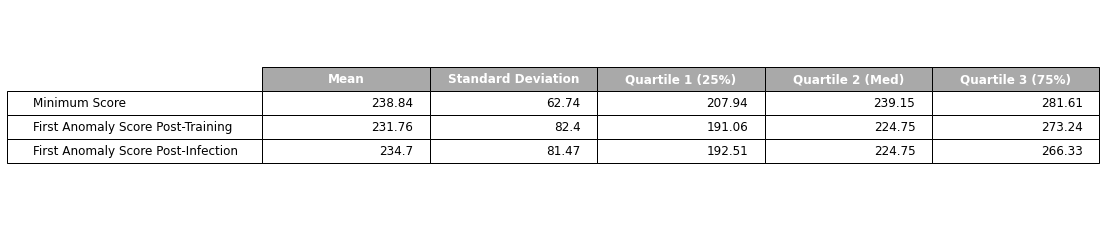

In [32]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table1 = ax.table(cellText=df1.values, colLabels=df.columns1, rowLabels=df.index1, loc='center')
table1.auto_set_font_size(True)
table1.set_fontsize(14)
table1.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns1):
    cell = table1[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')
    
# Save the table as an image file
#plt.savefig('table_statistics_4days.png', bbox_inches='tight', facecolor='white')


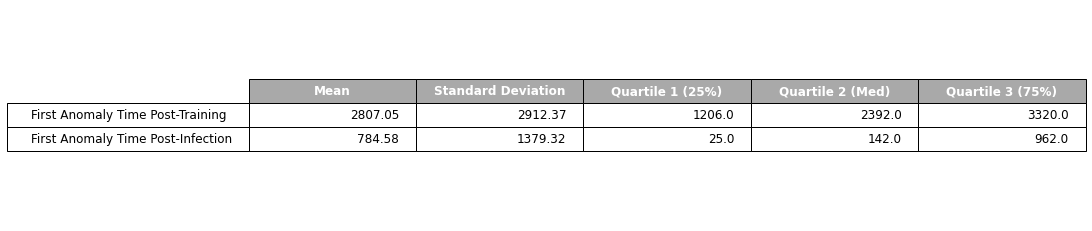

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table2 = ax.table(cellText=df2.values, colLabels=df.columns2, rowLabels=df.index2, loc='center')
table2.auto_set_font_size(True)
table2.set_fontsize(14)
table2.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns2):
    cell = table2[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')

ValueError: 'rowLabels' must be of length 5

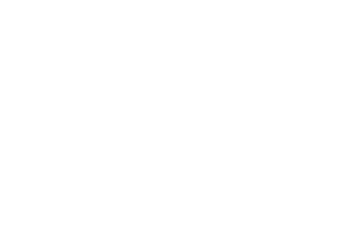

In [34]:

# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table3 = ax.table(cellText=df3.values, colLabels=df.columns3, rowLabels=df.index3, loc='center')
table3.auto_set_font_size(True)
table3.set_fontsize(14)
table3.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns3):
    cell = table3[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')

In [35]:
print("Mean: ", round(np.mean(ra)*100,2))
print("SD: ", round(np.std(ra)*100,2))
print("Q1: ", round(np.percentile(ra, 25)*100,2)) 
print("Q2: ", round(np.percentile(ra, 50)*100,2)) 
print("Q3: ", round(np.percentile(ra, 75)*100,2))

Mean:  23.59
SD:  30.21
Q1:  1.03
Q2:  7.7
Q3:  39.07


In [56]:
ra.min()

0.0

In [57]:
ra.max()

0.9185461749466626